In [14]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import math
import itertools
from random import choice

from datetime import datetime
from datetime import timedelta

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import pmdarima
from pmdarima.arima.utils import ndiffs

In [15]:
trading_portfolio = pd.ExcelFile('trading_portfolio.xlsx')
trading_portfolio #load the Excel file with data from all the sheets

In [16]:
trading_portfolio.sheet_names # output of this is a list of all the sheets within the Excel file
# therefore, you can loop through the sheet names and load them into dataframes individually

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

## Read one company stock info into a dataframe

In [17]:
# read one of the excel file sheets into a dataframe
df = pd.read_excel('trading_portfolio.xlsx', sheet_name = trading_portfolio.sheet_names[1])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      316 non-null    object 
 1   Price     316 non-null    object 
 2   Open      316 non-null    object 
 3   High      316 non-null    object 
 4   Low       316 non-null    object 
 5   Vol.      315 non-null    object 
 6   Change %  315 non-null    float64
dtypes: float64(1), object(6)
memory usage: 17.4+ KB


## Data cleaning

In [19]:
df = df[:-1].copy() #drop the last row by slicing and create a deep copy so that subsequent changes will not throw the warning
# 'A value is trying to be set on a copy of a slice from a DataFrame...'

In [20]:
# convert date from string object to datetime format

df['Date'] = pd.to_datetime(df['Date'])

In [21]:
# several of the columns are string objects. Convert to numeric
df[['Price','Open', 'High', 'Low', 'Change %']] = df[['Price','Open', 'High', 'Low', 'Change %']].apply(pd.to_numeric)

In [22]:
df['Vol.'] = df['Vol.'].apply(lambda x: x[:-1]).astype('float32') # for the volume column remove M (for millions)
# and then convert to float32 and normalize to the maximum

In [23]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31,19.41,19.42,19.63,19.27,13.140000,-0.0046
1,2021-03-30,19.50,19.12,19.81,19.03,21.049999,0.0209
2,2021-03-29,19.10,19.24,19.67,19.10,16.559999,-0.0078
3,2021-03-26,19.25,20.28,20.36,19.10,21.350000,-0.0385
4,2021-03-25,20.02,20.50,20.86,20.02,15.930000,-0.0148


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      315 non-null    datetime64[ns]
 1   Price     315 non-null    float64       
 2   Open      315 non-null    float64       
 3   High      315 non-null    float64       
 4   Low       315 non-null    float64       
 5   Vol.      315 non-null    float32       
 6   Change %  315 non-null    float64       
dtypes: datetime64[ns](1), float32(1), float64(5)
memory usage: 16.1 KB


## Plot the stock price vs the date in 2020 and 2021

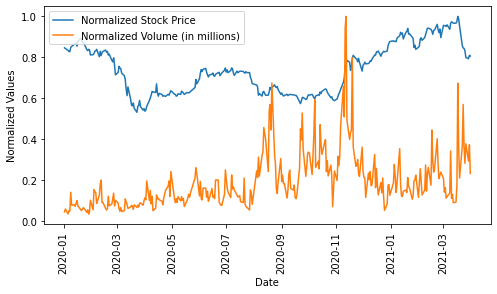

In [25]:
# plot the 'Price' and 'Vol.' columns, both normalized to their maximum values (so as to observe if there are trends between
# the stock price and the volume)
plt.figure(figsize = (8,4))
sns.lineplot(x = df['Date'], y = df['Price']/df['Price'].max())
sns.lineplot(x = df['Date'], y = df['Vol.']/df['Vol.'].max())
plt.xticks(rotation= 90)
plt.ylabel('Normalized Values')
plt.legend(loc = 'upper left', labels= ['Normalized Stock Price','Normalized Volume (in millions)'])
plt.show()
#there is no clear trend. Some increases in the price (between 2020-11 and 2021-01) is preceded by large transaction volumes
# while others (e.g. between 2020-4 and 2020-6) is not. 
# So transaction volumnes may not be a good indicator of a subsequent increase in stock prices

# 1) Predicting daily stock prices

## Create training and testing data from closing stock prices
## All prices from 2020 - > Training
## All prices from 2021 -> testing

In [26]:
# for the dataset, we will use all Q1 - Q4 data from 2020 for training and Q1 data from 2021 as testing
# select 2021 Q1 data as follows
# select just the Price column and convert values to a list form
X_test = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Price'].values)
X_test[:20]#truncated display

[19.41,
 19.5,
 19.1,
 19.25,
 20.02,
 20.32,
 20.36,
 20.66,
 22.94,
 23.78,
 24.08,
 23.48,
 23.28,
 23.28,
 23.36,
 23.44,
 23.26,
 22.56,
 23.08,
 22.9]

In [27]:
# likewise, selecte all data from 2020 for training the model
X_train = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Price'].values)
X_train[:20] #truncated display

[21.12,
 20.94,
 20.62,
 20.0,
 19.9,
 19.97,
 19.84,
 19.68,
 19.39,
 20.0,
 19.89,
 19.91,
 19.52,
 19.54,
 19.05,
 18.8,
 18.85,
 18.62,
 18.53,
 18.49]

In [28]:
len(X_train), len(X_test)

(252, 63)

## Do a grid-search-like method to identify the optimal values p, d, q values for an ARIMA model

In [29]:
# define the ranges of values p and q can take on from 0 to 4 (range 0 to but not including 5)
p=q=range(0,5)
# define the values of d to be 1 or 2 (first or second order differencing only)
d=(1,2)

#create a list of all combinations of p,d and q values (cartersian products)
pdq = list(itertools.product(p,d,q))
pdq[:10] #first 10 of the pdq value combinations

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4)]

In [30]:
len(pdq)

50

Following code block is similar to doing a grid-search to identify optimal parameters.

For each pdq combination, determine AIC and BIC values while at the same time doing exception handling and warning detection.
If an error is generated with a particular pdq combination, continue to the next value
If a warning is generated (e.g. Convergence warning), the AIC and BIC values are flagged to be removed later.
For each pdq combination, loop through the length of X_test and append each X_test value to X_train, in a similar manner as would be done when using the model to predict next day's share price

The code block below is marked down after the first run since it took a long time to run.

In [ ]:

pdq_aic_bic = {'pdq':[], 'aic': [], 'bic': [], 'warning': []}

num_test_obser = len(X_test)

for params in pdq:
    
    for i in range(num_test_obser):
    
        # some of the p,d,q parameters may generate errors, therefor use exception handling to avoid them while running the
        # pdq values
        try:

            model_grid_search = ARIMA(X_train, order = params)

            #some p,d,q values may generate warnings, use catch_warnings to located which of the p,d,q value sets
            # generated the warnings
            with warnings.catch_warnings (record=True) as caught_warning:
                warnings.simplefilter("always")
                #fit the model
                model_gs_fit =  model_grid_search.fit()

                if len(caught_warning)>0: #if caught_warning list length is not zero, append the number of warnings to the
                    #pdq_aic_bic dictionary
                    pdq_aic_bic['warning'].append(len(caught_warning))

                else: # if the waught_warning is zero, append zero to the dictionary
                    pdq_aic_bic['warning'].append(0)

            # append the params, aic and bic values to the dicstionary
            pdq_aic_bic['pdq'].append(params)
            pdq_aic_bic['aic'].append(model_gs_fit.aic)
            pdq_aic_bic['bic'].append(model_gs_fit.bic)
            
            # add each value of X_test to X_train, in a similar manner as when predictions are carried out later 
            X_train.append(X_test[i])

        except:
            # if the try code generates an error, add each value of X_test to X_train, in a similar manner 
            # as when predictions are carried out later and move to the next X_test value (share price)m
            X_train.append(X_test[i])
            continue
        

In [65]:
aic_bic_df = pd.read_csv('pdq_aic_bic.csv') # read the csv file
aic_bic_df['aic_bic_avg'] = (aic_bic_df['aic']+aic_bic_df['bic'])/2

#### If the above code block used to do the grid-searhc is run, following lines of code creates a dataframe

aic_bic_df = pd.DataFrame(pdq_aic_bic)   
aic_bic_df['aic_bic_avg'] = (pd.DataFrame(pdq_aic_bic)['aic']+pd.DataFrame(pdq_aic_bic)['bic'])/2

In [34]:
aic_bic_df.shape

(3150, 6)

Save the data into a csv file so that the grid_search (above) need not be run again

aic_bic_df.to_csv('pdq_aic_bic.csv') #save to csv file

In [67]:
#create a new df where warning ==0 (i.e. exclude all pdq combinations that generated a warning)
pdq_filtered = aic_bic_df[aic_bic_df['warning']==0]
pdq_filtered.shape

(2077, 6)

In [68]:
pdq_filtered[pdq_filtered['aic_bic_avg'] == pdq_filtered['aic_bic_avg'].min()]

,Unnamed: 0,pdq,aic,bic,warning,aic_bic_avg
0,0,"(0, 1, 0)",367.941237,371.69063,0,369.815934


In [38]:
# the following line of code extracts the row from the dataframe where the least average of aic and bic values in the above df .
# all these values were associated with p,d,q of 0 , 1, 0
pdq_filtered[(pdq_filtered['aic_bic_avg'] > 300) & (pdq_filtered['aic_bic_avg'] < 400)]

,Unnamed: 0,pdq,aic,bic,warning,aic_bic_avg
0,0,"(0, 1, 0)",367.941237,371.690630,0,367.941237
1,1,"(0, 1, 0)",384.773153,388.525726,0,384.773153
2,2,"(0, 1, 0)",385.027890,388.783632,0,385.027890
3,3,"(0, 1, 0)",386.053116,389.812018,0,386.053116
4,4,"(0, 1, 0)",386.377824,390.139875,0,386.377824
5,5,"(0, 1, 0)",389.603660,393.368851,0,389.603660
6,6,"(0, 1, 0)",390.274317,394.042638,0,390.274317
7,7,"(0, 1, 0)",390.494261,394.265702,0,390.494261
8,8,"(0, 1, 0)",391.162321,394.936873,0,391.162321


It is clear that the best ARIMA parameters are p = q = 0 and d = 1 (this are the same values that were obtained when auto ARIMA was run in a previous version of this project). 
In the best ARIMA model, a single differencing is sufficient to forecast the share prices
So we will start using the values p = 2, d = 1 and q = 3 in our initial ARIMA model

In [39]:
# use the above identified p, d and q values (0,1,0) to train the ARIMA model

model_predictions = []
num_test_obser = len(X_test)

for i in range(num_test_obser):
    model = ARIMA(X_train, order = (0, 1, 0)) # where p = 0 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make them stationary
                                              # q = 0 which is the size of the moving average window
    model_fit =  model.fit()
    output = model_fit.forecast()
    
    model_predictions.append (output[0]) # append the predicted value to the model2_predictions list
    
    true_test_value = X_test[i] # the corresponding test value of the X_test list
    X_train.append(true_test_value)

In [40]:
model_predictions[:10] # compare predictions to actual share prices (next line of code)

[20.38, 19.41, 19.5, 19.1, 19.25, 20.02, 20.32, 20.36, 20.66, 22.94]

In [41]:
X_test[:10]

[19.41, 19.5, 19.1, 19.25, 20.02, 20.32, 20.36, 20.66, 22.94, 23.78]

<AxesSubplot:xlabel='Date'>

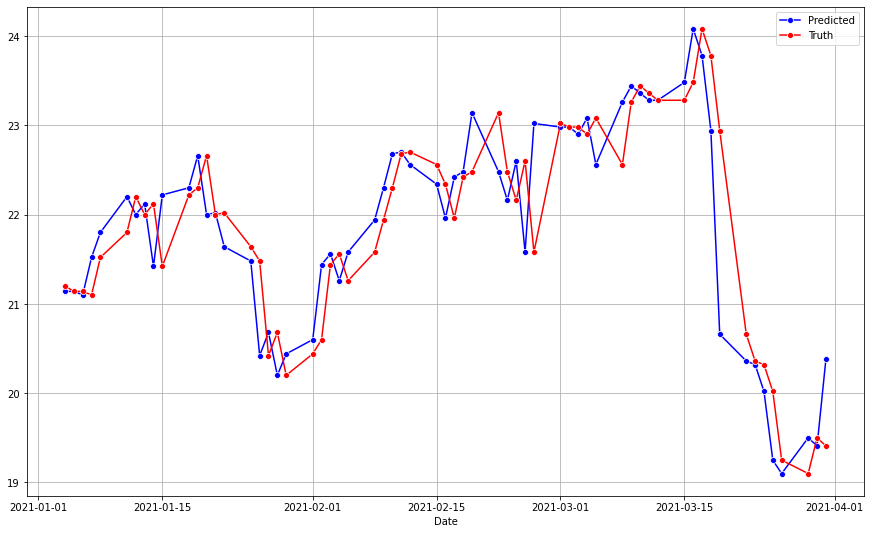

In [42]:
# plot the predicted and truth values for 2021

plt.figure(figsize = (15, 9))
plt.grid(True)

date_range = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'] # dates of the test data used for graph's X_axis
sns.lineplot(x=date_range, y=model_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=date_range, y=X_test, color = 'red', marker = 'o', label = 'Truth')
#there is an offset of one day between Predicted and Truth values

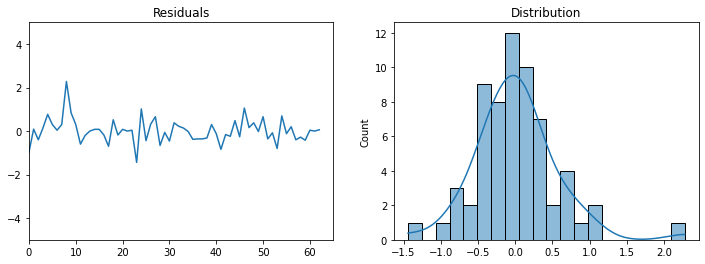

In [43]:
residuals = np.array(X_test) - np.array(model_predictions)
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.lineplot(x=range(len(residuals)), y = residuals, ax=axes[0])
axes[0].set_ylim([-5, 5])
axes[0].set_xlim([0, 65])
axes[0].set_title("Residuals")
sns.histplot(x=residuals, bins=20, kde=True, ax=axes[1])
axes[1].set_title("Distribution")
plt.show()
# the residual errors have a mean of 0 and variance that is normally distributed around mean of 0

In [44]:
# calculate the error metrics for model2_fit
MAE = mean_absolute_error(model_predictions, X_test)
MSE = mean_squared_error(model_predictions, X_test)
MAPE = mean_absolute_percentage_error(model_predictions, X_test)
print('Mean Absolute Error :', MAE)
print('Mean Squared Error :', MSE)
print('Mean Absolute Percentage Error :', MAPE)


Mean Absolute Error : 0.38857142857142835
Mean Squared Error : 0.3019428571428571
Mean Absolute Percentage Error : 0.017928811046444677


## ARIMAX - use share volume data as an exogenous factor?

In [45]:
X_train_exog = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Vol.'].values)

In [46]:
X_test_exog = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Vol.'].values)

In [47]:
len(X_train_exog), len(X_test_exog)

(252, 63)

In [48]:
model_arimax_predictions = []
num_test_obser = len(X_test)

#redefine X_train, X_test, X_train_exog and X_test_exog values each time this code block is run
# (since the X_train and X_train_exog lists increase in length)
X_train = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Price'].values)
X_test = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Price'].values)
X_train_exog = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Vol.'].values)
X_test_exog = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Vol.'].values)

for i in range(num_test_obser):
    model_arimax = ARIMA(X_train, order = (0, 1, 0), exog=X_train_exog) # where p = 0 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make them stationary
                                              # q = 0 which is the size of the moving average window
    model_arimax_fit =  model_arimax.fit()
    output_arimax = model_arimax_fit.forecast(exog=X_test_exog[i])# need to provide the corresponding exogenous value for 
                                                                  #each forecast
    
    model_arimax_predictions.append (output_arimax[0]) # append the predicted value to the model2_predictions list
    
    true_test_value = X_test[i] # the corresponding test value of the X_test list
    true_exog_value = X_test_exog[i]
    X_train.append(true_test_value)
    X_train_exog.append(true_exog_value)

In [49]:
print(model_arimax_fit.summary()) # the p value for exogenous variable (X1) is greater than 0.5 indicating 
# it has little predictive capability for the share price

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  314
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -182.326
Date:                Mon, 08 Aug 2022   AIC                            368.652
Time:                        23:00:20   BIC                            376.145
Sample:                             0   HQIC                           371.646
                                - 314                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0045      0.003      1.353      0.176      -0.002       0.011
sigma2         0.1877      0.010     19.292      0.000       0.169       0.207
Ljung-Box (L1) (Q):                   0.27   Jarque-

<AxesSubplot:xlabel='Date'>

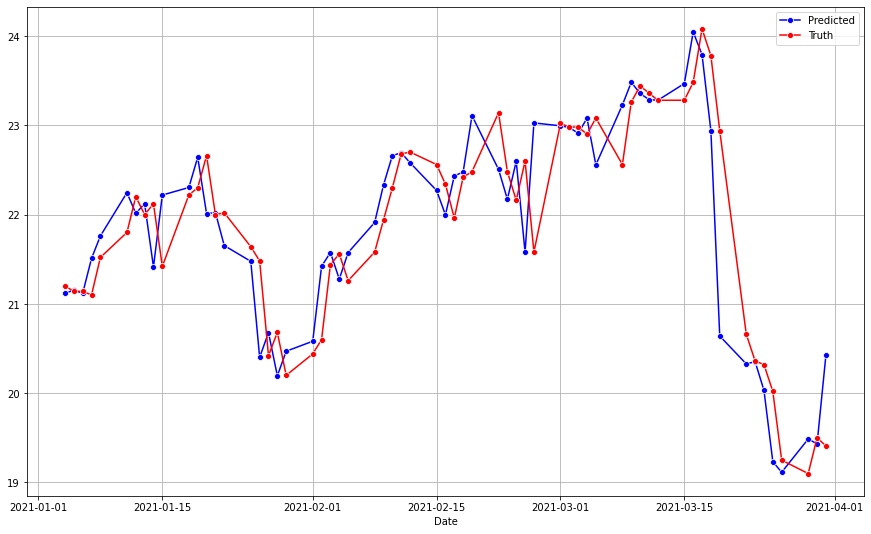

In [50]:
# plot the predicted and truth values for 2021 using exogenous variable (i.e. ARIMAX)

plt.figure(figsize = (15, 9))
plt.grid(True)

date_range = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'] # dates of the test data used for graph's X_axis
sns.lineplot(x=date_range, y=model_arimax_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=date_range, y=X_test, color = 'red', marker = 'o', label = 'Truth')
#there is an offset of one day between Predicted and Truth values

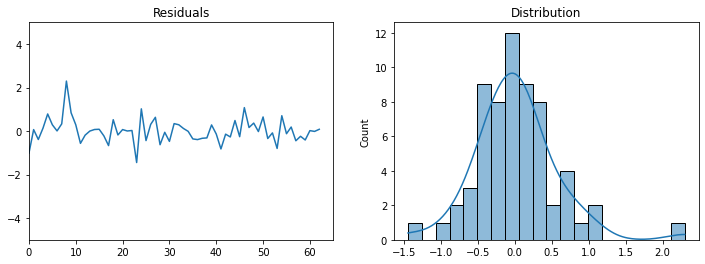

In [51]:
residuals_arimax = np.array(X_test) - np.array(model_arimax_predictions)
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.lineplot(x=range(len(residuals_arimax)), y = residuals_arimax, ax=axes[0])
axes[0].set_ylim([-5, 5])
axes[0].set_xlim([0, 65])
axes[0].set_title("Residuals")
sns.histplot(x=residuals_arimax, bins=20, kde=True, ax=axes[1])
axes[1].set_title("Distribution")
plt.show()
# the residual errors in ARIMAX are pretty similar

In [52]:
# calculate the error metrics for model_arimax_fit
MAE = mean_absolute_error(model_arimax_predictions, X_test)
MSE = mean_squared_error(model_arimax_predictions, X_test)
MAPE = mean_absolute_percentage_error(model_arimax_predictions, X_test)
print('Mean Absolute Error :', MAE)
print('Mean Squared Error :', MSE)
print('Mean Absolute Percentage Error :', MAPE)
# these metrics are very similar to those of the first model (model_fit)

Mean Absolute Error : 0.38643217701315313
Mean Squared Error : 0.30290077049391284
Mean Absolute Percentage Error : 0.017840010316503535


## How effective is random trading in helping to make money?
## Random trading can then be compared to how well an ARIMA model will perform

In [53]:
#specify starting and ending dates (this is the data available from 2021 that can be used in simulations)
starting_date = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'].min()
ending_date = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'].max()

In [56]:
#define functions for buying or selling shares. It is assumed that trading commissions are not charged for buying or selling

# for buying shares
def buy_shares(capital_available, share_price): # assume no commissions for buying
    """ Input: capital available to buy shares at the specified share price
        Output: the number of whole shares bought and the balance available after the purchase
    """
    num_shares_bought = int(capital_available/share_price)
    money_left = capital_available - (num_shares_bought* share_price)
    return num_shares_bought, round(money_left,2)


#for selling shares
def sell_shares (num_shares, share_price): # assume no commisions for selling
    """ Input:  tnumber of shares to be sold at the specified share price
        Output: the total proceeds from the sale
    """
    proceeds = num_shares * share_price
    return round(proceeds,2)

In [54]:
# following block of code loops through all the dates between starting and ending dates for each run of random trades.

sh = ['sell', 'hold']
bh = ['buy', 'hold']

def run_simulation(num_cycles, starting_capital):
    
    starting_capital = starting_capital
    
    #specify a dictionary to store the total number of cycles, ending capital of after each cycle and loss/gain after each cycle
    end_capital = {'num':0,
                   'tot_capital':[],
                   'loss_gain':[]}
    
    for cycle in range (num_cycles):
        
    
        for i in (df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'][::-1]):
            if i == starting_date:
                choose_trade = 'buy'
                num_shares_bought, money_left = buy_shares(starting_capital, df[df['Date'] == i]['Price'].iloc[0])
                #print('First', choose_trade, num_shares_bought, money_left)

            elif i == ending_date:

                if choose_trade == 'buy': # if the previous to last date was a 'buy', then sell the shares
                    proceeds = sell_shares(num_shares_bought, df[df['Date'] == i]['Price'].iloc[0])
                    ending_capital = round(proceeds+money_left, 2)
                    loss_or_gain = round(ending_capital - starting_capital, 2)
                    #print('Last a', ending_capital, loss_or_gain)
                    
                    end_capital['num']+=1
                    end_capital['tot_capital'].append(ending_capital)
                    end_capital['loss_gain'].append(loss_or_gain)
                    
                elif choose_trade == 'sell': # if previous to last was a 'sell', then ending capital is the money_left
                    ending_capital = money_left
                    loss_or_gain = round(ending_capital - starting_capital, 2)
                    #print('Last b', ending_capital, loss_or_gain)
                    
                    end_capital['num']+=1
                    end_capital['tot_capital'].append(ending_capital)
                    end_capital['loss_gain'].append(loss_or_gain)

                else: # if previous to last was a 'hold', then sell
                    ending_capital = sell_shares (num_shares_bought,df[df['Date'] == i]['Price'].iloc[0])
                    loss_or_gain = round(ending_capital - starting_capital, 2)
                    #print('Last c', ending_capital, loss_or_gain)
                    
                    end_capital['num']+=1
                    end_capital['tot_capital'].append(ending_capital)
                    end_capital['loss_gain'].append(loss_or_gain)

            elif choose_trade == 'buy':
                choose_trade = choice(sh) 
                if choose_trade == 'sell':
                    money_left+= sell_shares(num_shares_bought, df[df['Date'] == i]['Price'].iloc[0])
                    #print ('3a', choose_trade, round(money_left,2))        
                else:
                    #print('3b', choose_trade, round(money_left,2))
                    continue

            elif choose_trade == 'sell':
                choose_trade = 'buy'
                num_shares_bought, money_left = buy_shares (money_left, df[df['Date'] == i]['Price'].iloc[0])
                #print ('4', choose_trade, num_shares_bought, round(money_left,2))

            else:
                choose_trade =  choice (sh)
                if choose_trade == 'sell':
                    money_left += sell_shares(num_shares_bought, df[df['Date'] == i]['Price'].iloc[0])
                    #print('5a', choose_trade, round(money_left,2))
                else:
                    #print('5b', choose_trade, round(money_left,2))
                    continue
                    
    return end_capital        

In [57]:
# run the above simulation many times (say 1000) with a starting capital of $1000 (or the currency of the share price)

dict_1 = run_simulation(2000, 1000) #run 2000- simulations with $1000 in each simulation

ending_capital = round(np.array(dict_1['tot_capital']).mean(), 2)
ending_loss_gain = round(np.array(dict_1['loss_gain']).mean(), 2)

ending_capital, ending_loss_gain

(941.21, -58.79)

In [58]:
dict_1

{'num': 2000,
 'tot_capital': [951.09,
  803.17,
  854.04,
  1069.96,
  857.96,
  817.96,
  815.22,
  892.86,
  892.86,
  912.8,
  1002.56,
  1084.68,
  1224.41,
  917.61,
  1050.61,
  737.58,
  989.91,
  1074.29,
  845.09,
  986.92,
  912.27,
  1079.1,
  791.38,
  955.54,
  991.87,
  834.63,
  991.33,
  951.09,
  1187.76,
  1048.16,
  939.63,
  978.94,
  924.57,
  913.06,
  926.2,
  906.22,
  1028.73,
  834.87,
  892.86,
  763.94,
  945.36,
  931.68,
  927.49,
  812.83,
  1022.54,
  931.68,
  1012.8,
  1009.27,
  1145.19,
  737.58,
  917.73,
  924.54,
  1064.06,
  995.18,
  813.05,
  867.93,
  1009.32,
  830.62,
  778.32,
  930.43,
  815.22,
  931.59,
  989.91,
  1016.73,
  872.7,
  927.55,
  1024.24,
  999.36,
  945.04,
  938.7,
  968.09,
  977.81,
  892.86,
  966.21,
  955.16,
  869.78,
  1076.61,
  1195.23,
  913.96,
  823.18,
  1004.42,
  931.68,
  915.24,
  873.45,
  871.71,
  905.06,
  1048.14,
  892.86,
  1009.32,
  931.68,
  832.76,
  1168.29,
  893.65,
  874.18,
  989.91,
  8

The average capital at the end of each run is about $60 lower than starting. So on average, you are losing money when you randomly select trading (buy, sell or hold).

Text(0.5, 1.0, 'Random Buy, Sell or Hold')

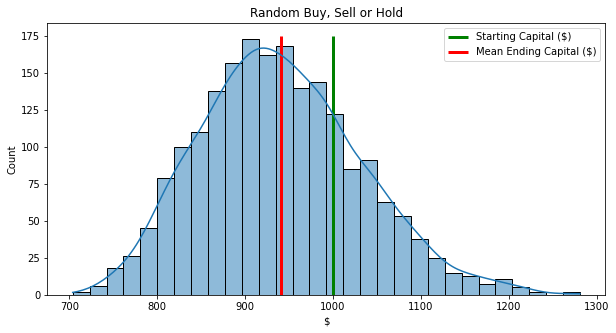

In [59]:
# plot the distribution of the capital left at the end after running the random trade simulation (e.g.1000 times)
plt.figure(figsize=(10,5))
sns.histplot(data = dict_1, x=dict_1['tot_capital'], bins = 30, kde=True)
plt.vlines(x=1000, ymin = 0, ymax=175, color='g', linewidth=3, label = 'Starting Capital ($)')
plt.vlines(x=np.array(dict_1['tot_capital']).mean(), ymin = 0, ymax=175, color='r', linewidth=3, label = 'Mean Ending Capital ($)')
plt.legend()
plt.xlabel('$')
plt.title('Random Buy, Sell or Hold')

In [57]:
np.array(X_train_2[-20:]).std()*2

0.9454200124812249

## Make educated guesses on trade position based on forecast share price

In [60]:
X_train = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Price'].values)
X_test = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Price'].values)

In [61]:
len(X_train), len(X_test)

(252, 63)

In [62]:
# make deep copies of the training and testing data (because values from X_test list get added to X_train list with each loop)
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()

num_test_obser = len(X_test_2)

starting_capital = 1000

threshold_sd = 2 # threshold level of std dev of the trailing average that is used to make a decision

position = 0 # position = 0, does not own shares, position = 1 own shares

num_shares_bought = 0

for i in range(num_test_obser):
    model_arima1 = ARIMA(X_train_2, order = (0, 1, 0)) # where p = 0 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make them stationary
                                              # q = 0 which is the size of the moving average window
    model_arima1_fit =  model_arima1.fit()
    output_arima1 = model_arima1_fit.forecast()
    
    trailing_avg = np.array(X_train_2[-20:]).mean()
    trailing_std = np.array(X_train_2[-20:]).std()*threshold_sd
    
    print('round :', i)
    if i == 0:
        
        if output_arima1[0] <= (trailing_avg - trailing_std): # if predicted price is less than the threhold std dev
            #then BUY the shares with the starting capital
            num_shares_bought, money_left = buy_shares(starting_capital, X_train_2[-1]) 
            position = 1 # set position to 1 indicating owning shares
            print('1a', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)
            
        elif output_arima1[0] >= (trailing_avg + trailing_std):# if predicted price is greater than the threhold std dev
            #but there is nothing to sell, so HOLD
            money_left = starting_capital 
            print('1b', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)
            
        else: money_left = starting_capital
            
    elif output_arima1[0] <= (trailing_avg - trailing_std) and position ==0: #if predicted price is less than the threhold std dev
        # and no shares are owned, BUY shares
        print(money_left)
        num_shares_bought, money_left = buy_shares(money_left, X_train_2[-1])
        position = 1
        print('2', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)
    
    elif output_arima1[0] <= (trailing_avg - trailing_std) and position ==1: #if predicted price is less than the threhold std dev
        # and you already own shares, HOLD shares
        print(money_left)
        print('3', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)
    
    
    elif output_arima1[0] >= (trailing_avg + trailing_std) and position ==0: #if predicted price is greater than the threhold std dev
        # and no shares are owned, then HOLD cash
        print(money_left)
        num_shares_bought, money_left = buy_shares(money_left, X_train_2[-1])
        position = 1
        print('4', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)
        
        
    elif output_arima1[0] >= (trailing_avg + trailing_std) and position ==1: #if predicted price is less than the threhold std dev
        # and you already own shares, SELL shares
        print(money_left)
        money_left+= sell_shares(num_shares_bought, X_train_2[-1])
        position = 0
        print('5', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)
        
    true_test_value = X_test_2[i] # the corresponding test value of the X_test list
    X_train_2.append(true_test_value)
    
# at the end of the period, if shares are owned, sell and calculate loss/gain
if position == 1:
    money_left+= sell_shares(num_shares_bought, X_train_2[-1])
    loss_or_gain = round(money_left - starting_capital, 2)
    print('capital at end :', money_left)
    print('Loss/Gain :', loss_or_gain)
    
# if shares are not owned, just calculate loss/gain
else:
    loss_or_gain = round(money_left - starting_capital, 2)
    print('capital at end :', money_left)
    print('Loss/Gain :', loss_or_gain)
    
            

round : 0
round : 1
1000
2 19.41 19.502301726397953 51 10.09
round : 2
round : 3
10.09
3 19.1 19.191570894584856 51 10.09
round : 4
round : 5
round : 6
round : 7
round : 8
round : 9
10.09
5 22.94 18.729322946234415 51 1180.03
round : 10
1180.03
4 23.78 18.285150872179422 49 14.81
round : 11
14.81
5 24.08 17.94195645555483 49 1194.73
round : 12
round : 13
round : 14
round : 15
round : 16
round : 17
round : 18
round : 19
round : 20
round : 21
round : 22
round : 23
round : 24
round : 25
round : 26
round : 27
round : 28
round : 29
round : 30
round : 31
round : 32
round : 33
round : 34
round : 35
round : 36
round : 37
round : 38
round : 39
1194.73
2 21.26 21.38098043071573 56 4.17
round : 40
round : 41
round : 42
4.17
3 20.6 20.889784018659178 56 4.17
round : 43
4.17
3 20.44 20.62550514255736 56 4.17
round : 44
4.17
3 20.2 20.35475584738831 56 4.17
round : 45
round : 46
round : 47
round : 48
round : 49
round : 50
round : 51
round : 52
round : 53
round : 54
round : 55
round : 56
round : 57
r

# Code below work in progress

# Predicting average monthly stock prices

In [340]:
# extract monthly average stock prices and save in train or test lists

month_train = []
month_test = []

for i in range (1,13):
    month_train.append(df[(pd.DatetimeIndex(df['Date']).year == 2020) & (pd.DatetimeIndex(df['Date']).month == i)]['Price'].mean())
    month_test.append(df[(pd.DatetimeIndex(df['Date']).year == 2021) & (pd.DatetimeIndex(df['Date']).month == i)]['Price'].mean())
    
#remove null values from a list if a month is missing (especially true for months in an incomplete year e.g. 2021)
month_train = [x for x in month_train if str(x) !='nan']
month_test = [x for x in month_test if str(x) != 'nan']


In [341]:
# run an ARIMA model for predicting the monthly average stock price 

month_predictions = []
month_test_obser = len(month_test)

for i in range(month_test_obser):
    model_month = ARIMA(month_train, order = (0, 1, 0)) # where p = 10 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make the tren stationary
                                              # q = 0 which is the size of the moving average window
    model_month_fit =  model_month.fit()
    output_month = model_month_fit.forecast()
    
    month_predictions.append (output_month[0]) # append the predicted value to the model_predictions list
    
    month_test_value = month_test[i] # the corresponding test value of the month_test list
    month_train.append(month_test_value) # update the training dataset by appending the true_test_value. 
                                    # This will be used in the next training round

In [342]:
print(model_month_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   14
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -26.687
Date:                Mon, 08 Aug 2022   AIC                             55.375
Time:                        15:52:13   BIC                             55.940
Sample:                             0   HQIC                            55.259
                                 - 14                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.5532      1.359      2.615      0.009       0.890       6.217
Ljung-Box (L1) (Q):                   2.79   Jarque-Bera (JB):                 1.30
Prob(Q):                              0.09   Pr

<AxesSubplot:>

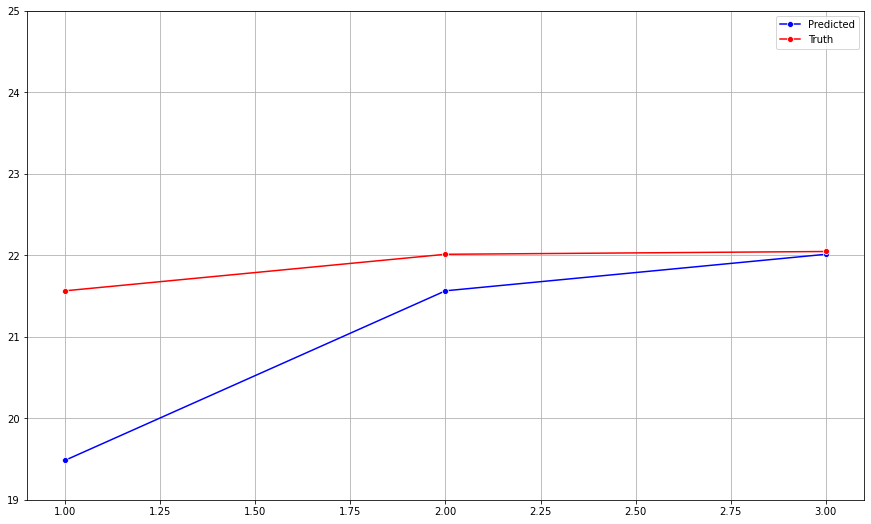

In [343]:
plt.figure(figsize = (15, 9))
plt.grid(True)
plt.ylim(ymin=19, ymax=25)

month_range = [1,2,3]

sns.lineplot(x=month_range, y=month_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=month_range, y=month_test, color = 'red', marker = 'o', label = 'Truth')

# Predicting weekly stock prices

In [344]:
import warnings
warnings.filterwarnings('ignore')
# ignore warnings for the following lines of code for week determination

In [345]:
# extract the weekly stock price averages for training and testing data
week_train = []
week_test = []

for i in range (1,54):
    week_train.append(df[(pd.DatetimeIndex(df['Date']).year == 2020) & (pd.DatetimeIndex(df['Date']).week == i)]['Price'].mean())
    week_test.append(df[(pd.DatetimeIndex(df['Date']).year == 2021) & (pd.DatetimeIndex(df['Date']).week == i)]['Price'].mean())
    
#remove null values from the list if a week is missing (especially true for weeks in an incomplete year, e.g. 2021)
week_train = [x for x in week_train if str(x) !='nan']
week_test = [x for x in week_test if str(x) != 'nan']

In [348]:
# run an ARIMA model for preciting average weekly stock price
week_predictions = []
week_test_obser = len(week_test)

for i in range(week_test_obser):
    model_week = ARIMA(week_train, order = (0, 1, 0)) # where p = 10 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make the tren stationary
                                              # q = 0 which is the size of the moving average window
    model_week_fit =  model_week.fit()
    output_week = model_week_fit.forecast()
    
    week_predictions.append (output_week[0]) # append the predicted value to the model_predictions list
    
    week_test_value = week_test[i] # the corresponding test value of the month_test list
    week_train.append(week_test_value) # update the training dataset by appending the true_test_value. 
                                    # This will be used in the next training round

In [349]:
print(model_week_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   78
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -106.576
Date:                Mon, 08 Aug 2022   AIC                            215.153
Time:                        15:52:51   BIC                            217.496
Sample:                             0   HQIC                           216.090
                                 - 78                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9327      0.094      9.891      0.000       0.748       1.118
Ljung-Box (L1) (Q):                   2.88   Jarque-Bera (JB):                41.94
Prob(Q):                              0.09   Pr

<AxesSubplot:>

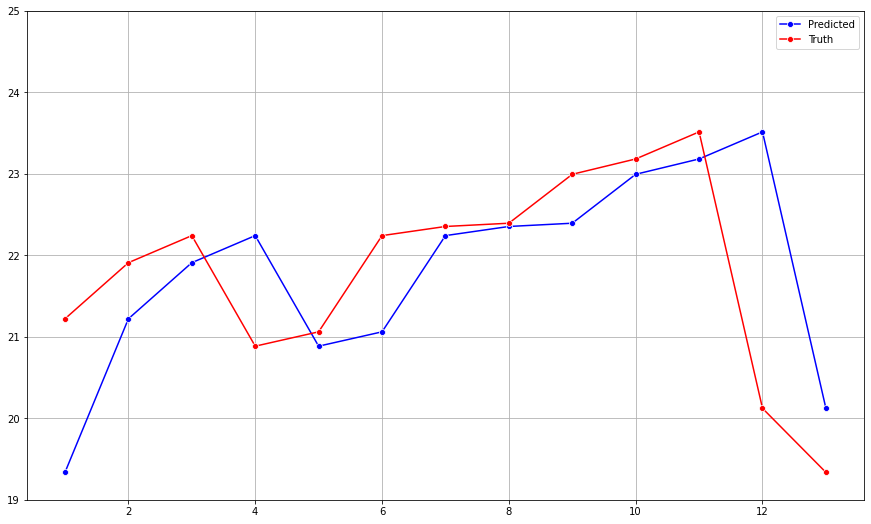

In [350]:
plt.figure(figsize = (15, 9))
plt.grid(True)
plt.ylim(ymin=19, ymax=25)

week_range = [1,2,3,4,5,6,7,8,9,10,11,12,13]

sns.lineplot(x=week_range, y=week_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=week_range, y=week_test, color = 'red', marker = 'o', label = 'Truth')